In [1]:
install.packages("mapplots")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(keras)
library(repr)

In [3]:
data.bkg  <- read.csv("data/P_LHCB_LambdaB/background.csv")
data.sig  <- read.csv("data/P_LHCB_LambdaB/MC_signal.csv")
data.lhcb <- read.csv("data/P_LHCB_LambdaB/data_lhcb.csv")

In [4]:
data.cutted.bkg  <-  data.bkg  %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)
data.cutted.sig  <-  data.sig  %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)
data.cutted.lhcb <-  data.lhcb %>% dplyr::filter( (Lambda_b0_MM_F > 5550 &  Lambda_b0_MM_F < 5680 ) |  DeltaM_F < 360)

In [5]:
# test set <- 400 sig 400 bkg

sel_features <- c(3, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18)
nt_bkg <- 400; nt_sig <- 400

x_test_bkg  <- as.matrix(data.bkg[1:nt_bkg, sel_features])
x_test_sig  <- as.matrix(data.sig[1:nt_sig, sel_features])

y_test_bkg  <- as.vector(matrix(0, nrow=nt_bkg, ncol=1))
y_test_sig  <- as.vector(matrix(1, nrow=nt_sig, ncol=1))

x_test  <- rbind(x_test_bkg  , x_test_sig  )
y_test  <-     c(y_test_bkg  , y_test_sig  )

x_test  <- scale(x_test )

shuffle_test  <- sample(nrow(x_test ))
x_test  <- x_test [shuffle_test,]
y_test  <- y_test [shuffle_test] 



In [6]:
#training set, dimension give with function

x_train_bkg_full <- as.matrix(data.bkg[-1:-nt_bkg, sel_features])
x_train_sig_full <- as.matrix(data.sig[-1:-nt_sig, sel_features])

y_train_bkg_full <- as.vector(matrix(0, nrow=nrow(x_train_bkg_full), ncol=1))
y_train_sig_full <- as.vector(matrix(1, nrow=nrow(x_train_sig_full), ncol=1))

get_train_data <- function(n_bkg, n_sig=1090 ){
    x_bkg <- x_train_bkg_full[1:n_bkg, ]
    x_sig <- x_train_sig_full[1:n_sig, ]
    x_t   <- rbind(x_bkg, x_sig)
    y_t   <- c(y_train_bkg_full[1:n_bkg], y_train_sig_full[1:n_sig])
    sffl  <- sample(nrow(x_t))
    
    x_t   <- x_t[sffl,]
    x_t   <- scale(x_t)
    y_t   <- y_t[sffl] 
    return (list(x_train=x_t, y_train=y_t))
}


In [7]:
# lhcb data
x_lhcb     <- as.matrix(       data.lhcb[, sel_features])
x_cut_lhcb <- as.matrix(data.cutted.lhcb[, sel_features])

x_lhcb     <- scale(x_lhcb)
x_cut_lhcb <- scale(x_cut_lhcb)


In [8]:
build_model <- function(params){
    model <- keras_model_sequential()
    model %>%
      layer_dense(units = params$unit1, activation = 'relu', 
                  input_shape = c(params$nFeat), 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout1) %>%
      layer_dense(units = params$unit2, activation = 'relu',  
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout2) %>%
      layer_dense(units = params$unit3, activation = 'relu', 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout3) %>%
      layer_dense(units = 1, activation = 'sigmoid')

    model %>% compile(
      loss = 'binary_crossentropy',
      optimizer = optimizer_rmsprop(),
      metrics = c('accuracy')
    )
    return(model)
}

ModelParams <- flags(
    flag_numeric("dropout1", 0.1),
    flag_numeric("dropout2", 0.1),
    flag_numeric("dropout3", 0.1),
    flag_numeric("unit1", 128),
    flag_numeric("unit2", 64),
    flag_numeric("unit3", 32),
    flag_numeric("nFeat", length(sel_features)),
    flag_numeric("l1_coeff", 1e-4),
    flag_numeric("l2_coeff", 1e-5)
)

loss  accuracy 
0.5113398 0.8412500

`geom_smooth()` using formula 'y ~ x'


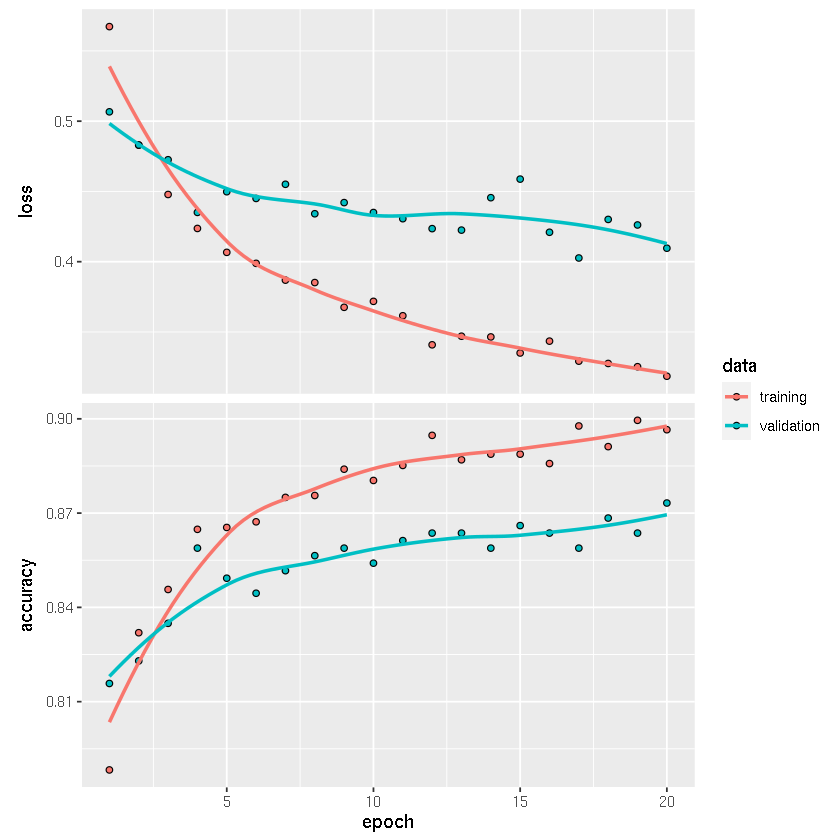

In [9]:
model <- build_model(ModelParams)
data  <- get_train_data(1000) 
history  <- model %>% fit (data$x_train, data$y_train, verbose=2,
                     epochs=20, batch_size=10, validation_split=0.2)
model %>% evaluate(x_test, y_test)
plot(history)

In [14]:
save_model_hdf5(model, "Models/Test/TestModel.hdf5")

In [10]:
y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)

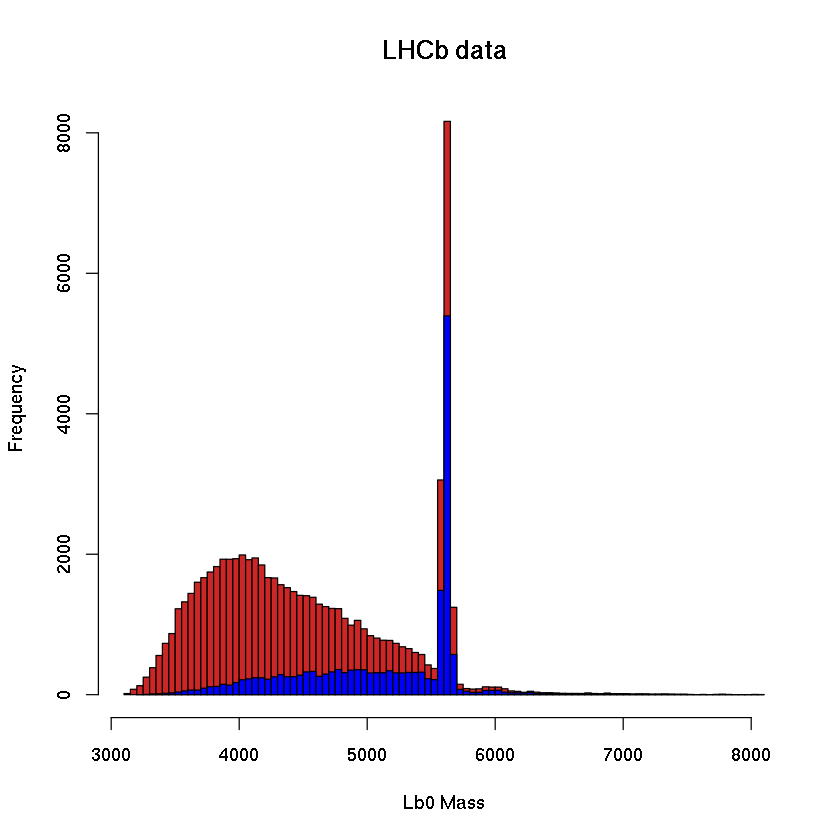

In [11]:
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.0],   breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.9], breaks=100, add=TRUE, col='blue')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.2], breaks=100, add=TRUE, col='green')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.3], breaks=100, add=TRUE, col='orange')
#hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.5], breaks=100, add=TRUE, col='black')


In [12]:
cv_tune_builder <- function (builder, params, x, y, cv=4, name="Test"){
    l=as.integer(nrow(x)/cv)
    accs <- NULL
    for(i in 0:(cv-1)){
        x_tr <- x[-(i*l+1):-(l*(i+1)),]; x_cv <- x[(i*l+1):(l*(i+1)),]; 
        y_tr <- y[-(i*l+1):-(l*(i+1)) ]; y_cv <- y[(i*l+1):(l*(i+1)) ];
        model <- builder(params)
        eph    = ifelse('epochs'     %in% names(params), params$epochs     , 30  )
        b_size = ifelse('batch_size' %in% names(params), params$batch_size , 10 )
        hist  <- model %>% fit (x_tr, y_tr,  epochs = eph, batch_size = b_size, validation_data = list(x_cv, y_cv))
        stats <- model %>% evaluate(x_test, y_test)
        accs <- c(accs, stats[[2]])
        mName <- paste(name, "_cv",i,".hdf5", sep="")
        save_model_hdf5(model, mName)
    }
    return (accs)
}


tune_builder <- function(builder, par_default, par_list, cv=4, verbose=FALSE, path="Models/Test/"){
    if(!dir.exists(path)){
        dir.create(path)
    }
    grid = expand.grid(par_list)
    mean_accs <- NULL
    best_acc <- 0.0
    par_best <- rlang::duplicate(par_default, shallow=FALSE)
    for(i in 1:nrow(grid)){
        par_copy <- rlang::duplicate(par_default, shallow=FALSE)
        mName <- "Model"
        for (name in names(par_list)){
            par_copy[[name]] <- grid[[name]][i]
            mName <- paste(mName,"_",name, grid[[name]][i], sep="")
        }
        data <- get_train_data(par_copy$n_bkg, par_copy$n_sig) #get dataset
        x <- data$x_train; y<-data$y_train;
        acc <- cv_tune_builder(builder, par_copy, x, y, cv, paste(path,mName, sep=""))
        mean_accs <- c(mean_accs, mean(acc))
        if(verbose){
            print("Parameters: ")
            print(par_copy)
            print("Accuracies:")
            print(acc)
            print(paste("Mean: ", mean(acc)))
        }
        if (mean(acc)>best_acc){
            best_acc <- mean(acc)
            par_best <- rlang::duplicate(par_copy, shallow=FALSE)
        }        
    }
    if(verbose){
        print("Best Parameters: ")
        print(par_best)
        print(paste("Accuracy:", best_acc))
    }
    grid$Mean_acc <- mean_accs
    #return(par_best)
    return (grid)
}

In [153]:
TunerParams <- flags(
    flag_numeric("dropout1"   , 0.1                 ),
    flag_numeric("dropout2"   , 0.1                 ),
    flag_numeric("dropout3"   , 0.1                 ),
    flag_numeric("unit1"      , 128                 ),
    flag_numeric("unit2"      , 64                  ),
    flag_numeric("unit3"      , 32                  ),
    flag_numeric("nFeat"      , length(sel_features)),
    flag_numeric("l1_coeff"   , 1e-4                ),
    flag_numeric("l2_coeff"   , 1e-5                ),
    flag_string ("epochs"     , 30                  ),  
    flag_string ("batch_size" , 10                  ),
    flag_numeric("n_bkg"      , 1000                ),
    flag_numeric("n_sig"      , 1090                )            
)

In [148]:
NBkgList <- list(n_bkg= c(500 , 750 , 1000, 1500,
                          2000, 2500, 3000), 
                 epochs=(20))

tuned_grid <- tune_builder(build_model, TunerParams, NBkgList, 4, FALSE, "Models/BkgNum/" )

print(tuned_grid)

#

  n_bkg epochs  Mean_acc
1   500     20 0,7940625
2   750     20 0,8340625
3  1000     20 0,8443750
4  1500     20 0,8265625
5  2000     20 0,7906250
6  2500     20 0,7771875
7  3000     20 0,7415625


In [155]:
#Batch_Epoch_List <- list(batch_size=c(1, 5, 10,20,50, 100), 
#               epochs=c(5,10,20))
Batch_Epoch_List <- list(batch_size=c( 10), 
               epochs=c(5,10,20, 30, 50, 75, 100, 150, 200, 300))

tuned_grid <- tune_builder(build_model, TunerParams, Batch_Epoch_List, 4, FALSE, "Models/Batch_Epoch/" )

print(tuned_grid)

Model_batch_size10
Model_batch_size10_epochs5
Model_batch_size10
Model_batch_size10_epochs10
Model_batch_size10
Model_batch_size10_epochs20
Model_batch_size10
Model_batch_size10_epochs30
Model_batch_size10
Model_batch_size10_epochs50
Model_batch_size10
Model_batch_size10_epochs75
Model_batch_size10
Model_batch_size10_epochs100
Model_batch_size10
Model_batch_size10_epochs150
Model_batch_size10
Model_batch_size10_epochs200
Model_batch_size10
Model_batch_size10_epochs300


   batch_size epochs  Mean_acc
1          10      5 0,8456250
2          10     10 0,8450000
3          10     20 0,8409375
4          10     30 0,8406250
5          10     50 0,8350000
6          10     75 0,8328125
7          10    100 0,8312500
8          10    150 0,8300000
9          10    200 0,8253125
10         10    300 0,8231250


In [37]:
getOptimizer <- function (params){
    if (params$optimizer == "rmsprop"){
        return (optimizer_rmsprop(lr = params$lr, rho=params$rho))}
    if (params$optimizer == "adam"){
        return (optimizer_adam(lr = params$lr, beta_1 = params$beta_1, 
                                               beta_2 = params$beta_2 ))}
    if (params$optimizer == "nadam"){
        return (optimizer_nadam(lr = params$lr, beta_1 = params$beta_1, 
                                                beta_2 = params$beta_2 ))}
    if (params$optimizer == "sgd"){
        return (optimizer_sgd(lr = params$lr, momentum = params$momentum, 
                               decay = 1e-6, nesterov = TRUE)) }
}


Archi_build_model <- function(params){
    model <- keras_model_sequential()
    model %>%
      layer_dense(units = params$unit1, activation = params$act_dense, 
                  input_shape = c(params$nFeat), 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout1) %>%
      layer_dense(units = params$unit2, activation = params$act_dense,  
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout2) %>%
      layer_dense(units = params$unit3, activation = params$act_dense, 
                  kernel_regularizer=regularizer_l1_l2(l1=params$l1_coeff, l2=params$l2_coeff)) %>%
      layer_dropout(rate = params$dropout3) %>%
      layer_dense(units = 1, activation = params$act_final)

    model %>% compile(
      loss = params$loss,
      optimizer = getOptimizer(params),
      metrics = c('accuracy')
    )
    return(model)
}

ArchiParams <- flags(
    flag_numeric("dropout1"   , 0.1                   ),
    flag_numeric("dropout2"   , 0.1                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 128                   ),
    flag_numeric("unit2"      , 64                    ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-4                  ),
    flag_numeric("l2_coeff"   , 1e-5                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "sigmoid"             ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.001                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

In [161]:
Units_List <- list(unit1=c(256,128, 64),
                   unit2=c(128, 64, 32),
                   unit3=c( 64, 32, 16))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams, Units_List, 4, FALSE,
                           "Models/Units/" )

print(tuned_grid)

   unit1 unit2 unit3  Mean_acc
1    256   128    64 0,8400000
2    128   128    64 0,8484375
3     64   128    64 0,8471875
4    256    64    64 0,8437500
5    128    64    64 0,8434375
6     64    64    64 0,8400000
7    256    32    64 0,8440625
8    128    32    64 0,8425000
9     64    32    64 0,8475000
10   256   128    32 0,8453125
11   128   128    32 0,8478125
12    64   128    32 0,8503125
13   256    64    32 0,8353125
14   128    64    32 0,8462500
15    64    64    32 0,8434375
16   256    32    32 0,8384375
17   128    32    32 0,8406250
18    64    32    32 0,8456250
19   256   128    16 0,8440625
20   128   128    16 0,8462500
21    64   128    16 0,8368750
22   256    64    16 0,8478125
23   128    64    16 0,8462500
24    64    64    16 0,8440625
25   256    32    16 0,8468750
26   128    32    16 0,8406250
27    64    32    16 0,8478125


In [162]:
Dropout_List <- list(dropout1=c(0.1, 0.2, 0.3),
                     dropout2=c(0.1, 0.2, 0.3),
                     dropout3=c(0.1, 0.2, 0.3))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams, Dropout_List, 4, FALSE,
                           "Models/Dropouts/" )

print(tuned_grid)

   dropout1 dropout2 dropout3  Mean_acc
1       0,1      0,1      0,1 0,8437500
2       0,2      0,1      0,1 0,8462500
3       0,3      0,1      0,1 0,8437500
4       0,1      0,2      0,1 0,8431250
5       0,2      0,2      0,1 0,8406250
6       0,3      0,2      0,1 0,8453125
7       0,1      0,3      0,1 0,8481250
8       0,2      0,3      0,1 0,8450000
9       0,3      0,3      0,1 0,8512500
10      0,1      0,1      0,2 0,8450000
11      0,2      0,1      0,2 0,8453125
12      0,3      0,1      0,2 0,8384375
13      0,1      0,2      0,2 0,8381250
14      0,2      0,2      0,2 0,8437500
15      0,3      0,2      0,2 0,8440625
16      0,1      0,3      0,2 0,8478125
17      0,2      0,3      0,2 0,8446875
18      0,3      0,3      0,2 0,8459375
19      0,1      0,1      0,3 0,8406250
20      0,2      0,1      0,3 0,8503125
21      0,3      0,1      0,3 0,8409375
22      0,1      0,2      0,3 0,8350000
23      0,2      0,2      0,3 0,8468750
24      0,3      0,2      0,3 0,8381250


In [28]:
ArchiParams_TunedUnit <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-4                  ),
    flag_numeric("l2_coeff"   , 1e-5                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "sigmoid"             ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.001                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

In [29]:
Activation_List <- list(act_dense=c( "relu"   ,  "elu", "selu", "linear"),
                        act_final=c( "sigmoid", "softmax", "hard_sigmoid" ))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedUnit, Activation_List, 4, FALSE,
                           "Models/Activation/" )

print(tuned_grid)

   act_dense    act_final  Mean_acc
1       relu      sigmoid 0,8396875
2        elu      sigmoid 0,8393750
3       selu      sigmoid 0,8381250
4     linear      sigmoid 0,8137500
5       relu      softmax 0,5000000
6        elu      softmax 0,5000000
7       selu      softmax 0,5000000
8     linear      softmax 0,5000000
9       relu hard_sigmoid 0,8400000
10       elu hard_sigmoid 0,8362500
11      selu hard_sigmoid 0,8337500
12    linear hard_sigmoid 0,8103125


In [30]:
Loss_List <- list(loss=c( "binary_crossentropy", "poisson",
                              "kullback_leibler_divergence", "hinge",
                              "mean_squared_error", "mean_absolute_error"))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedUnit, Loss_List, 4, FALSE,
                           "Models/Loss/" )

print(tuned_grid)

                         loss  Mean_acc
1         binary_crossentropy 0,8453125
2                     poisson 0,8353125
3 kullback_leibler_divergence 0,5000000
4                       hinge 0,8331250
5          mean_squared_error 0,8428125
6         mean_absolute_error 0,8228125


In [51]:
ArchiParams_TunedLayers <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-4                  ),
    flag_numeric("l2_coeff"   , 1e-5                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.001                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

In [37]:
RMS_List <-  list(optimizer="rmsprop",
                  lr = c( 0.007, 0.005 ,  0.003),
                  rho= c(0.98 ,  0.95,  0.93,  0.9))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedLayers, RMS_List, 4, FALSE,
                           "Models/Optimizers/RMS/" )

print(tuned_grid)

   optimizer    lr  rho  Mean_acc
1    rmsprop 0,007 0,98 0,8312500
2    rmsprop 0,005 0,98 0,8340625
3    rmsprop 0,003 0,98 0,8437500
4    rmsprop 0,007 0,95 0,8368750
5    rmsprop 0,005 0,95 0,8425000
6    rmsprop 0,003 0,95 0,8471875
7    rmsprop 0,007 0,93 0,8396875
8    rmsprop 0,005 0,93 0,8346875
9    rmsprop 0,003 0,93 0,8393750
10   rmsprop 0,007 0,90 0,8384375
11   rmsprop 0,005 0,90 0,8400000
12   rmsprop 0,003 0,90 0,8490625


In [ ]:
model <- Archi_build_model(ArchiParams_TunedLayers)
data  <- get_train_data(1000) 
history  <- model %>% fit (data$x_train, data$y_train, verbose=2,
                     epochs=10, batch_size=5, validation_split=0.2)
model %>% evaluate(x_test, y_test)
plot(history)
y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)

In [ ]:
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.0],   breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.9973], breaks=100, add=TRUE, col='blue')


In [ ]:
ADAM_List <-  list(optimizer="adam",
                  lr     = c(0.003, 0.001, 5e-4,  3e-4, 1e-4  ),
                  beta_1 = c( 0.87,   0.9, 0.93  ),
                  beta_2 = c( 0.99, 0.995, 0.999 ))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedLayers, ADAM_List, 4, FALSE,
                           "Models/Optimizers/ADAM/" )

print(tuned_grid)

In [54]:
print(tuned_grid)

   optimizer    lr beta_1 beta_2  Mean_acc
1       adam 3e-03   0,87  0,990 0,8328125
2       adam 1e-03   0,87  0,990 0,8371875
3       adam 5e-04   0,87  0,990 0,8384375
4       adam 3e-04   0,87  0,990 0,8350000
5       adam 1e-04   0,87  0,990 0,8196875
6       adam 3e-03   0,90  0,990 0,8306250
7       adam 1e-03   0,90  0,990 0,8365625
8       adam 5e-04   0,90  0,990 0,8365625
9       adam 3e-04   0,90  0,990 0,8365625
10      adam 1e-04   0,90  0,990 0,8215625
11      adam 3e-03   0,93  0,990 0,8415625
12      adam 1e-03   0,93  0,990 0,8337500
13      adam 5e-04   0,93  0,990 0,8340625
14      adam 3e-04   0,93  0,990 0,8387500
15      adam 1e-04   0,93  0,990 0,8215625
16      adam 3e-03   0,87  0,995 0,8303125
17      adam 1e-03   0,87  0,995 0,8371875
18      adam 5e-04   0,87  0,995 0,8356250
19      adam 3e-04   0,87  0,995 0,8359375
20      adam 1e-04   0,87  0,995 0,8240625
21      adam 3e-03   0,90  0,995 0,8315625
22      adam 1e-03   0,90  0,995 0,8396875
23      ada

In [56]:
NADAM_List <-  list(optimizer="nadam",
                  lr     = c(0.003, 0.001, 5e-4,  3e-4, 1e-4  ),
                  beta_1 = c( 0.87,   0.9, 0.93  ),
                  beta_2 = c( 0.99, 0.995, 0.999 ))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedLayers, NADAM_List, 4, FALSE,
                           "Models/Optimizers/NADAM/" )

print(tuned_grid)

   optimizer    lr beta_1 beta_2  Mean_acc
1      nadam 3e-03   0,87  0,990 0,8381250
2      nadam 1e-03   0,87  0,990 0,8390625
3      nadam 5e-04   0,87  0,990 0,8412500
4      nadam 3e-04   0,87  0,990 0,8353125
5      nadam 1e-04   0,87  0,990 0,8156250
6      nadam 3e-03   0,90  0,990 0,8378125
7      nadam 1e-03   0,90  0,990 0,8365625
8      nadam 5e-04   0,90  0,990 0,8365625
9      nadam 3e-04   0,90  0,990 0,8343750
10     nadam 1e-04   0,90  0,990 0,8165625
11     nadam 3e-03   0,93  0,990 0,8393750
12     nadam 1e-03   0,93  0,990 0,8368750
13     nadam 5e-04   0,93  0,990 0,8396875
14     nadam 3e-04   0,93  0,990 0,8334375
15     nadam 1e-04   0,93  0,990 0,8175000
16     nadam 3e-03   0,87  0,995 0,8325000
17     nadam 1e-03   0,87  0,995 0,8346875
18     nadam 5e-04   0,87  0,995 0,8318750
19     nadam 3e-04   0,87  0,995 0,8309375
20     nadam 1e-04   0,87  0,995 0,8134375
21     nadam 3e-03   0,90  0,995 0,8337500
22     nadam 1e-03   0,90  0,995 0,8293750
23     nada

In [60]:
SGD_List <-   list(optimizer="sgd",
                   lr       = c(0.01, 0.005, 0.001, 5e-4),
                   momentum = c( 0.92, 0.9))

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedLayers, SGD_List, 4, FALSE,
                           "Models/Optimizers/SGD/" )

print(tuned_grid)

  optimizer    lr momentum  Mean_acc
1       sgd 1e-02     0,92 0,5043750
2       sgd 5e-03     0,92 0,5821875
3       sgd 1e-03     0,92 0,6262500
4       sgd 5e-04     0,92 0,7812500
5       sgd 1e-02     0,90 0,5584375
6       sgd 5e-03     0,90 0,5937500
7       sgd 1e-03     0,90 0,8050000
8       sgd 5e-04     0,90 0,8181250


In [63]:
write.table(tuned_grid, "text.txt")

In [69]:
ArchiParams_TunedOpt <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-4                  ),
    flag_numeric("l2_coeff"   , 1e-5                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "sigmoid"             ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.001                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

In [65]:
#regularization analyssi with rms

Reg_List <-   list(l1_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   l2_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   optimizer="rmsprop", lr=0.003, rho=0.9)

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedOpt, Reg_List, 4, FALSE,
                           "Models/Regularization/" )

print(tuned_grid)
write.table(tuned_grid, "Reg_rms.txt")

   l1_coeff l2_coeff optimizer    lr rho  Mean_acc
1     1e-02    1e-02   rmsprop 0,003 0,9 0,5000000
2     1e-03    1e-02   rmsprop 0,003 0,9 0,8378125
3     1e-04    1e-02   rmsprop 0,003 0,9 0,8387500
4     1e-05    1e-02   rmsprop 0,003 0,9 0,8290625
5     1e-06    1e-02   rmsprop 0,003 0,9 0,8412500
6     0e+00    1e-02   rmsprop 0,003 0,9 0,8400000
7     1e-02    1e-03   rmsprop 0,003 0,9 0,7315625
8     1e-03    1e-03   rmsprop 0,003 0,9 0,8368750
9     1e-04    1e-03   rmsprop 0,003 0,9 0,8443750
10    1e-05    1e-03   rmsprop 0,003 0,9 0,8446875
11    1e-06    1e-03   rmsprop 0,003 0,9 0,8478125
12    0e+00    1e-03   rmsprop 0,003 0,9 0,8453125
13    1e-02    1e-04   rmsprop 0,003 0,9 0,6568750
14    1e-03    1e-04   rmsprop 0,003 0,9 0,8412500
15    1e-04    1e-04   rmsprop 0,003 0,9 0,8450000
16    1e-05    1e-04   rmsprop 0,003 0,9 0,8525000
17    1e-06    1e-04   rmsprop 0,003 0,9 0,8496875
18    0e+00    1e-04   rmsprop 0,003 0,9 0,8475000
19    1e-02    1e-05   rmsprop 

In [66]:
#regularization analyssi with adam

Reg_List <-   list(l1_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   l2_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   optimizer="adam", lr=1e-3, beta_1=0.93, beta_2=0.995)

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedOpt, Reg_List, 4, FALSE,
                           "Models/Regularization/" )

print(tuned_grid)
write.table(tuned_grid, "Reg_adam.txt")

   l1_coeff l2_coeff optimizer    lr beta_1 beta_2  Mean_acc
1     1e-02    1e-02      adam 0,001   0,93  0,995 0,5000000
2     1e-03    1e-02      adam 0,001   0,93  0,995 0,8381250
3     1e-04    1e-02      adam 0,001   0,93  0,995 0,8450000
4     1e-05    1e-02      adam 0,001   0,93  0,995 0,8512500
5     1e-06    1e-02      adam 0,001   0,93  0,995 0,8490625
6     0e+00    1e-02      adam 0,001   0,93  0,995 0,8431250
7     1e-02    1e-03      adam 0,001   0,93  0,995 0,6518750
8     1e-03    1e-03      adam 0,001   0,93  0,995 0,8453125
9     1e-04    1e-03      adam 0,001   0,93  0,995 0,8428125
10    1e-05    1e-03      adam 0,001   0,93  0,995 0,8434375
11    1e-06    1e-03      adam 0,001   0,93  0,995 0,8409375
12    0e+00    1e-03      adam 0,001   0,93  0,995 0,8468750
13    1e-02    1e-04      adam 0,001   0,93  0,995 0,5712500
14    1e-03    1e-04      adam 0,001   0,93  0,995 0,8478125
15    1e-04    1e-04      adam 0,001   0,93  0,995 0,8412500
16    1e-05    1e-04    

In [67]:
#regularization analyssi with nadam

Reg_List <-   list(l1_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   l2_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   optimizer="nadam", lr=5e-4, beta_1=0.9, beta_2=0.995)

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedOpt, Reg_List, 4, FALSE,
                           "Models/Regularization/" )

print(tuned_grid)
write.table(tuned_grid, "Reg_nadam.txt")

   l1_coeff l2_coeff optimizer    lr beta_1 beta_2  Mean_acc
1     1e-02    1e-02     nadam 5e-04    0,9  0,995 0,5746875
2     1e-03    1e-02     nadam 5e-04    0,9  0,995 0,8396875
3     1e-04    1e-02     nadam 5e-04    0,9  0,995 0,8403125
4     1e-05    1e-02     nadam 5e-04    0,9  0,995 0,8412500
5     1e-06    1e-02     nadam 5e-04    0,9  0,995 0,8465625
6     0e+00    1e-02     nadam 5e-04    0,9  0,995 0,8450000
7     1e-02    1e-03     nadam 5e-04    0,9  0,995 0,5759375
8     1e-03    1e-03     nadam 5e-04    0,9  0,995 0,8421875
9     1e-04    1e-03     nadam 5e-04    0,9  0,995 0,8465625
10    1e-05    1e-03     nadam 5e-04    0,9  0,995 0,8368750
11    1e-06    1e-03     nadam 5e-04    0,9  0,995 0,8459375
12    0e+00    1e-03     nadam 5e-04    0,9  0,995 0,8421875
13    1e-02    1e-04     nadam 5e-04    0,9  0,995 0,7359375
14    1e-03    1e-04     nadam 5e-04    0,9  0,995 0,8446875
15    1e-04    1e-04     nadam 5e-04    0,9  0,995 0,8525000
16    1e-05    1e-04    

In [70]:
#regularization analyssi with sgd

Reg_List <-   list(l1_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   l2_coeff= c(1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 0),
                   optimizer="sgd", lr=5e-4, momentum=0.9)

tuned_grid <- tune_builder(Archi_build_model, ArchiParams_TunedOpt, Reg_List, 4, FALSE,
                           "Models/Regularization/" )

print(tuned_grid)
write.table(tuned_grid, "Reg_sgd.txt")

   l1_coeff l2_coeff optimizer    lr momentum  Mean_acc
1     1e-02    1e-02       sgd 5e-04      0,9 0,6906250
2     1e-03    1e-02       sgd 5e-04      0,9 0,8209375
3     1e-04    1e-02       sgd 5e-04      0,9 0,8278125
4     1e-05    1e-02       sgd 5e-04      0,9 0,8237500
5     1e-06    1e-02       sgd 5e-04      0,9 0,8256250
6     0e+00    1e-02       sgd 5e-04      0,9 0,8190625
7     1e-02    1e-03       sgd 5e-04      0,9 0,7940625
8     1e-03    1e-03       sgd 5e-04      0,9 0,8281250
9     1e-04    1e-03       sgd 5e-04      0,9 0,8228125
10    1e-05    1e-03       sgd 5e-04      0,9 0,8268750
11    1e-06    1e-03       sgd 5e-04      0,9 0,8206250
12    0e+00    1e-03       sgd 5e-04      0,9 0,8228125
13    1e-02    1e-04       sgd 5e-04      0,9 0,7903125
14    1e-03    1e-04       sgd 5e-04      0,9 0,8225000
15    1e-04    1e-04       sgd 5e-04      0,9 0,8231250
16    1e-05    1e-04       sgd 5e-04      0,9 0,8237500
17    1e-06    1e-04       sgd 5e-04      0,9 0,

In [23]:
gr <- read.table("Reg_sgd.txt")
#print(gr)
str(gr)

gr[,1] <- ifelse(log10(gr[,1])!= -Inf, log10(gr[,1]), -7)
print(gr[,1])

'data.frame':	36 obs. of  6 variables:
 $ l1_coeff : num  1e-02 1e-03 1e-04 1e-05 1e-06 0e+00 1e-02 1e-03 1e-04 1e-05 ...
 $ l2_coeff : num  0,010 0,010 0,010 0,010 0,010 0,010 0,001 0,001 0,001 0,001 ...
 $ optimizer: Factor w/ 1 level "sgd": 1 1 1 1 1 1 1 1 1 1 ...
 $ lr       : num  5e-04 5e-04 5e-04 5e-04 5e-04 5e-04 5e-04 5e-04 5e-04 5e-04 ...
 $ momentum : num  0,9 0,9 0,9 0,9 0,9 0,9 0,9 0,9 0,9 0,9 ...
 $ Mean_acc : num  0,691 0,821 0,828 0,824 0,826 ...
 [1] -2 -3 -4 -5 -6 -7 -2 -3 -4 -5 -6 -7 -2 -3 -4 -5 -6 -7 -2 -3 -4 -5 -6 -7 -2
[26] -3 -4 -5 -6 -7 -2 -3 -4 -5 -6 -7


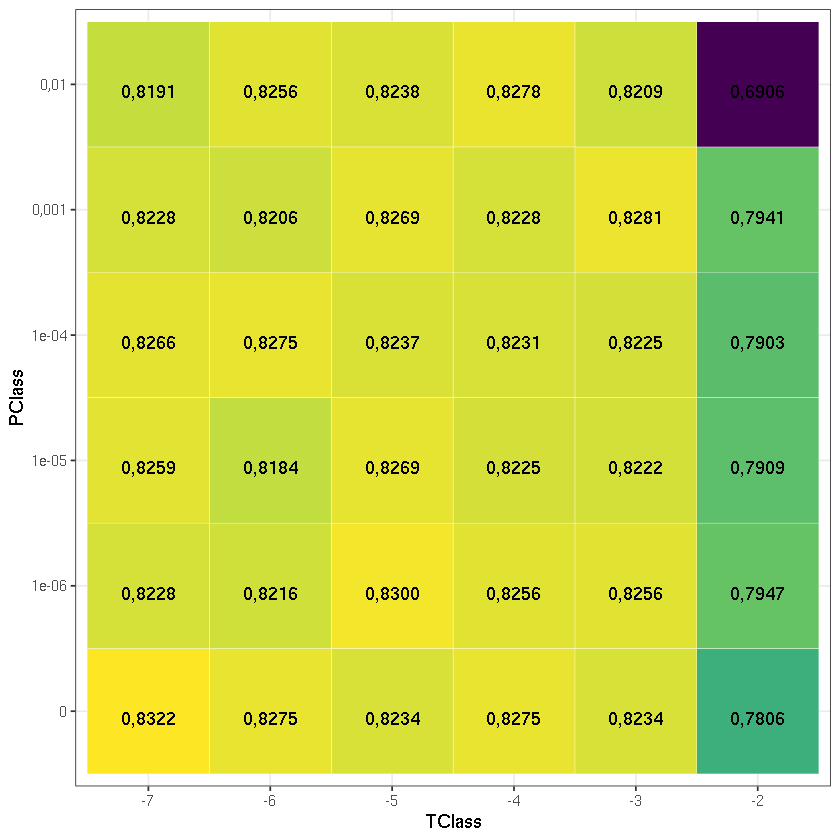

In [117]:
TClass <- factor(gr[,1])
PClass <- factor(gr[,2])
Y      <- gr[,"Mean_acc"]
df <- data.frame(TClass, PClass, Y)

library(ggplot2)
ggplot(data =  df, mapping = aes(x = TClass, y = PClass)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.4f", Y)), vjust = 1) +
scale_fill_continuous(type = "viridis") +
  theme_bw() + theme(legend.position = "none")

In [111]:
ArchiParams_RMS <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-5                  ),
    flag_numeric("l2_coeff"   , 1e-4                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "rmsprop"             ),
    flag_numeric("lr"         , 0.003                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

ArchiParams_ADAM <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-5                  ),
    flag_numeric("l2_coeff"   , 1e-2                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "adam"                ),
    flag_numeric("lr"         , 0.001                 ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.93                  ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.995                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)


ArchiParams_NADAM <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 1e-4                  ),
    flag_numeric("l2_coeff"   , 1e-4                  ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "nadam"               ),
    flag_numeric("lr"         , 5e-4                  ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.995                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

ArchiParams_SGD <- flags(
    flag_numeric("dropout1"   , 0.3                   ),
    flag_numeric("dropout2"   , 0.3                   ),
    flag_numeric("dropout3"   , 0.1                   ),
    flag_numeric("unit1"      , 64                    ),
    flag_numeric("unit2"      , 128                   ),
    flag_numeric("unit3"      , 32                    ),
    flag_numeric("nFeat"      , length(sel_features)  ),
    flag_numeric("l1_coeff"   , 0.0                   ),
    flag_numeric("l2_coeff"   , 0.0                   ),
    flag_string ("epochs"     , 10                    ),  
    flag_string ("batch_size" , 5                     ),
    flag_numeric("n_bkg"      , 1000                  ),
    flag_numeric("n_sig"      , 1090                  ),
    flag_string ("act_dense"  , "relu"                ),
    flag_string ("act_final"  , "hard_sigmoid"        ),
    flag_string ("loss"       , "binary_crossentropy" ),
    flag_string ("optimizer"  , "sgd"                 ),
    flag_numeric("lr"         , 5e-4                  ), #learing rate for the optimizers
    flag_numeric("rho"        , 0.9                   ), #rms rho
    flag_numeric("beta_1"     , 0.9                   ), #beta1 adam/nadam
    flag_numeric("beta_2"     , 0.999                 ), #beta2 adam/nadam
    flag_numeric("momentum"   , 0.9                   ) #momentum sgd
)

In [ ]:
drawPrediction <- function(builder, params, nbkg, prob, col){
    model <- builder(params)
    data  <- get_train_data(nbkg) 
    history  <- model %>% fit (data$x_train, data$y_train, verbose=0,
                     epochs=params$epochs, batch_size=params$, validation_split=0.2)
}

loss  accuracy 
0,5020906 0,7950000

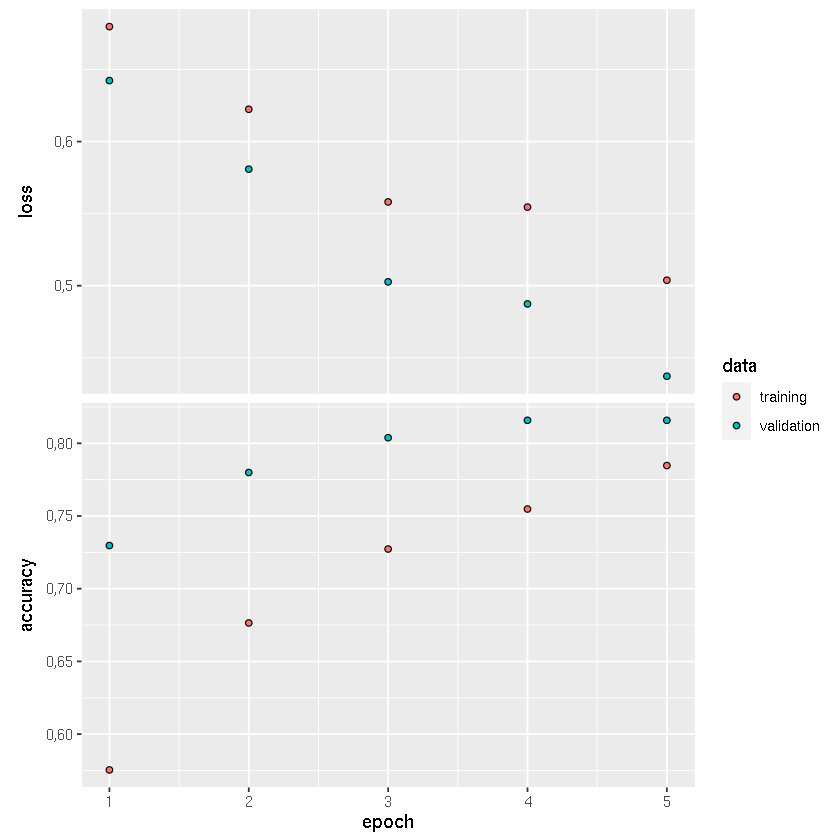

In [112]:
model <- Archi_build_model(ArchiParams_SGD)
data  <- get_train_data(1000) 
history  <- model %>% fit (data$x_train, data$y_train, verbose=2,
                     epochs=5, batch_size=5, validation_split=0.2)
model %>% evaluate(x_test, y_test)
plot(history)
y_cut_lhcb_pred <- model %>% predict(x_cut_lhcb)

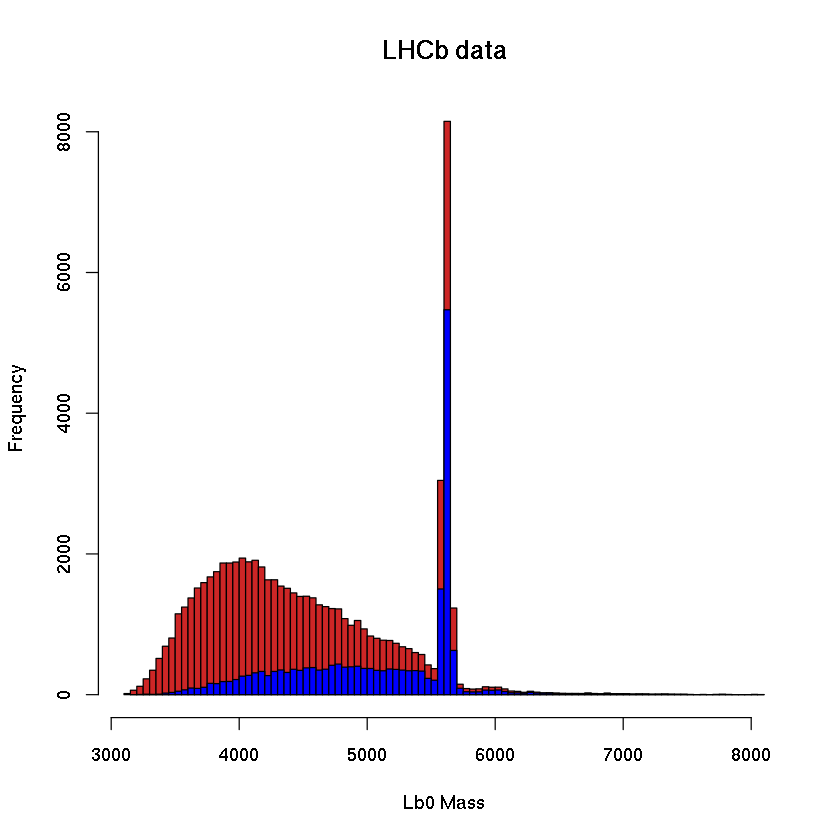

In [113]:
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.0],   breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.cutted.lhcb$Lambda_b0_MM_F[y_cut_lhcb_pred>0.68], breaks=100, add=TRUE, col='blue')


In [114]:
y_lhcb_pred <- model %>% predict(x_lhcb)

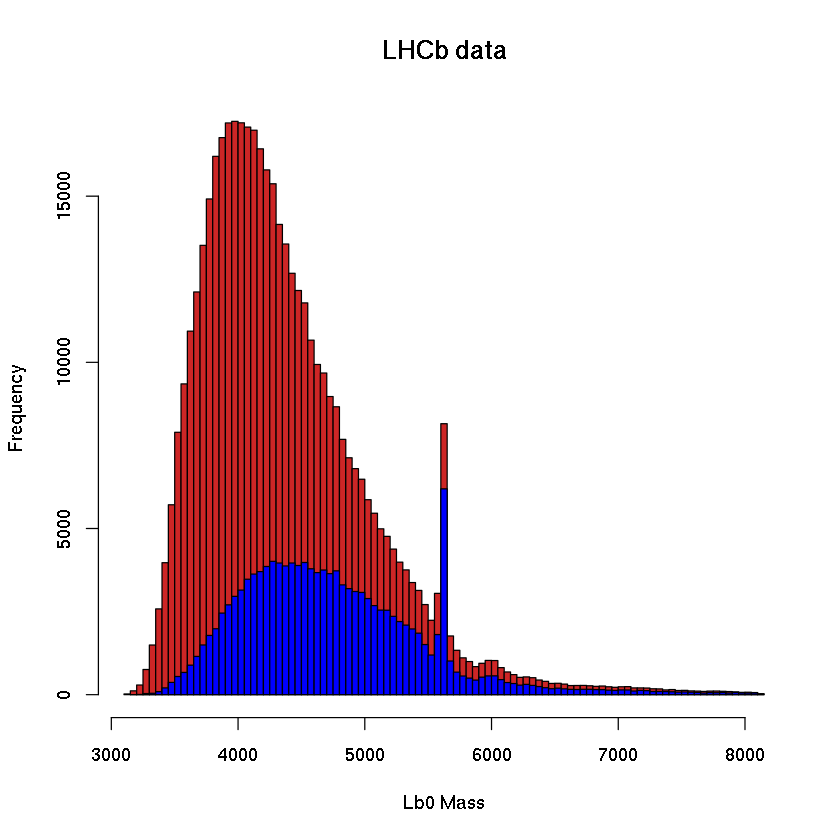

In [116]:
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>0.0],   breaks=100, col="firebrick3", xlab="Lb0 Mass", main="LHCb data",  probability=FALSE)
hist(data.lhcb$Lambda_b0_MM_F[y_lhcb_pred>0.68], breaks=100, add=TRUE, col='blue')
